In [217]:
import yfinance as yf
import datetime as dt
import pandas as pd
import numpy as np
from numpy import arange
import matplotlib.pyplot as plt
from pandas import read_csv

import ta as ta
from ta import add_all_ta_features
from ta.utils import dropna
from datetime import datetime

from tsmoothie.utils_func import sim_randomwalk
from tsmoothie.smoother import *

from sklearn.preprocessing import MinMaxScaler

import plotly.express as px
import plotly.graph_objects as go
import pandas as pd


from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

import joblib

import time

from scipy import signal

from statsmodels.tsa.seasonal import seasonal_decompose


def preparar_dados_para_treinamento(anteriores,base_treinamento_normalizada):

    previsores = []
    preco_real = []

    for i in range(anteriores,len(base_treinamento_normalizada)):

        previsores.append(base_treinamento_normalizada[i-anteriores:i,0])
        preco_real.append(base_treinamento_normalizada[i,0])

    previsores,preco_real = np.array(previsores),np.array(preco_real)
    previsores = previsores
    
    return previsores,preco_real

def GetTsi(base,):
    
    tsi_config=[25,13]

    resultados_tsi = ta.momentum.TSIIndicator(base["Close"],tsi_config[0],tsi_config[1],False)

    tsi_df = pd.DataFrame(resultados_tsi.tsi())
    
    tsi_df.dropna(inplace=True)
    
    return tsi_df


def Normalizar(Detrend_tsi):
    
    normalizador = MinMaxScaler(feature_range=(0,1))
    
    Oscilador_treinamento = Detrend_tsi["detrend_smooth"].values.reshape(-1,1)
        
    Oscilador_normalizado = normalizador.fit_transform(Oscilador_treinamento)
    
    return Oscilador_normalizado


def EscalarTSI(tsi):
    
    scaler = MinMaxScaler(feature_range=(1,2))

    tsi_np = np.array(tsi["tsi"])

    scaler.fit(tsi_np.reshape(-1,1))

    tsi_scaler = scaler.transform(tsi_np.reshape(-1,1))

    return pd.DataFrame(tsi_scaler,columns=["tsi_scaler"])


def RemoveTendenciaTSI(tsi_scaler_df,periodos=90):
    
    res = seasonal_decompose(tsi_scaler_df["tsi_scaler"], model='multiplicative', extrapolate_trend='freq',period=periodos)

    detrended = tsi_scaler_df["tsi_scaler"].values - res.trend

    return pd.DataFrame(detrended)


def AplicarGaussianDetrendTSI(detrended_df,n_knots_=90,sigma_=0.00009):
    
    detrend_np = detrended_df["trend"].to_numpy()

    detrend_np = detrend_np.reshape(1,len(detrend_np))

    smoother_tsi = GaussianSmoother(n_knots=n_knots_,sigma=sigma_)
    
    smoother_tsi.smooth(detrend_np)
    
    return pd.DataFrame(smoother_tsi.smooth_data[0],columns=["detrend_smooth"])

def AplicarGaussianTSI(tsi_scaler_df,n_knots_=90,sigma_=0.00009):
    
    scaler_np = tsi_scaler_df["tsi_scaler"].to_numpy()

    scaler_np = scaler_np.reshape(1,len(scaler_np))

    smoother_tsi = GaussianSmoother(n_knots=n_knots_,sigma=sigma_)
    
    smoother_tsi.smooth(scaler_np)
    
    return pd.DataFrame(smoother_tsi.smooth_data[0],columns=["detrend_smooth"])


def Carregar_modelo_randomForest(filepath):
    
    modelo = joblib.load(filepath)
    
    print("Modelo ",filepath," carregado")
    
    return modelo


def Realizar_previsoes_randomForest(qtd_previsoes,base,anteriores,modelo,periodos_=90,gaussian_knots_=60,gaussian_sigma_=0.00009):

    
    #A comparação é feita pelo TSI normal e não pelo tsi sem tendência
    ultimos_valores = base.tail(anteriores+37)
    
    tsi = GetTsi(ultimos_valores)

    tsi_scaler_df = EscalarTSI(tsi)

    tsi_smooth = AplicarGaussianTSI(tsi_scaler_df,n_knots_=gaussian_knots_,sigma_=gaussian_sigma_)

    tsi_smooth_normalizado = Normalizar(tsi_smooth)
    
    normalizado_reshape =tsi_smooth_normalizado.reshape(1,-1)
    
    lista_previsoes = list()

    i = 0

    while i < qtd_previsoes:

        previsao = modelo.predict(normalizado_reshape)

        lista_previsoes.append(previsao)

        normalizado_reshape =  np.append(normalizado_reshape,previsao)

        normalizado_reshape = np.delete(normalizado_reshape,0)

        normalizado_reshape =normalizado_reshape.reshape(1,-1)

        i+=1
    
    return lista_previsoes


def Criar_modelo_randomForest(base,anteriores_,filepath,periodos_=90,gaussian_knots_=60,gaussian_sigma_=0.0003,n_estimators_=100,max_depth_=None,min_samples_split_=2,min_samples_leaf_=1):
    
    tsi = GetTsi(base)
    
    #Escala os valores do tsi entre 1 e 2
    tsi_scaler_df = EscalarTSI(tsi)

    #Removendo a tendência sazonal do tsi
    detrended_df = RemoveTendenciaTSI(tsi_scaler_df,periodos=periodos_)

    #Aplicando o gaussian no tsi sem a tendência sazonal
    detrend_smooth = AplicarGaussianDetrendTSI(detrended_df,n_knots_=gaussian_knots_,sigma_=gaussian_sigma_)

    #Normaliza o detrend_smooth
    detrend_smooth_normalizado = Normalizar(detrend_smooth)
    
    

    #Prepara os dados para inserção no modelo
    X_train, y_train = preparar_dados_para_treinamento(anteriores_,detrend_smooth_normalizado)

    
    #Criar modelo
    forest_model = RandomForestRegressor(
            random_state=1,
            n_estimators=n_estimators_,
            max_depth=max_depth_,
            min_samples_split=min_samples_split_,
            min_samples_leaf=min_samples_leaf_)


    forest_model.fit(X_train, y_train)

    #joblib.dump(forest_model, "RandomForest_4.joblib")
    joblib.dump(forest_model, filepath)

    print("Modelo ",filepath, "criado")
    
    
def Criar_modelo_rf_1(base,filepath_):
    
    forest_model = Criar_modelo_randomForest(
        base,
        180,
        filepath_,
        periodos_=90,
        gaussian_knots_=90,
        gaussian_sigma_=0.00009,
        n_estimators_=200,
        max_depth_=100,
        min_samples_split_=4,
        min_samples_leaf_=5)
    
    return forest_model

def Criar_modelo_rf_2(base,filepath_):
    
    forest_model = Criar_modelo_randomForest(
        base,
        320,
        filepath_,
        periodos_=90,
        gaussian_knots_=90,
        gaussian_sigma_=0.00009,
        n_estimators_=200,
        max_depth_=100,
        min_samples_split_=4,
        min_samples_leaf_=5)
    
    return forest_model


def Criar_modelo_rf_3(base,filepath_):
    
    forest_model = Criar_modelo_randomForest(
        base,
        90,
        filepath_,
        periodos_=90,
        gaussian_knots_=90,
        gaussian_sigma_=0.00009,
        n_estimators_=200,
        max_depth_=100,
        min_samples_split_=4,
        min_samples_leaf_=5)
    
    return forest_model

In [94]:
ticker ="PETR3.SA"

base = yf.download(ticker)

base = base["2018":]

Criar_modelo_rf_1(base,"modelo_tsi_detrend_01.joblib")

modelo1=Carregar_modelo_randomForest("modelo_tsi_detrend_01.joblib")

[*********************100%***********************]  1 of 1 completed
Modelo  modelo_tsi_detrend_01.joblib criado


In [207]:
ticker ="PETR3.SA"

base = yf.download(ticker)

base = base["2018":]

Criar_modelo_rf_2(base,"modelo_tsi_detrend_02.joblib")



[*********************100%***********************]  1 of 1 completed
Modelo  modelo_tsi_detrend_02.joblib criado


In [209]:
modelo2=Carregar_modelo_randomForest("modelo_tsi_detrend_02.joblib")

Modelo  modelo_tsi_detrend_02.joblib  carregado


In [218]:
ticker ="PETR3.SA"

base = yf.download(ticker)

base = base["2018":]

Criar_modelo_rf_3(base,"modelo_tsi_detrend_03.joblib")

[*********************100%***********************]  1 of 1 completed
Modelo  modelo_tsi_detrend_03.joblib criado


In [219]:
modelo3=Carregar_modelo_randomForest("modelo_tsi_detrend_03.joblib")

Modelo  modelo_tsi_detrend_03.joblib  carregado


[*********************100%***********************]  1 of 1 completed


<AxesSubplot: >

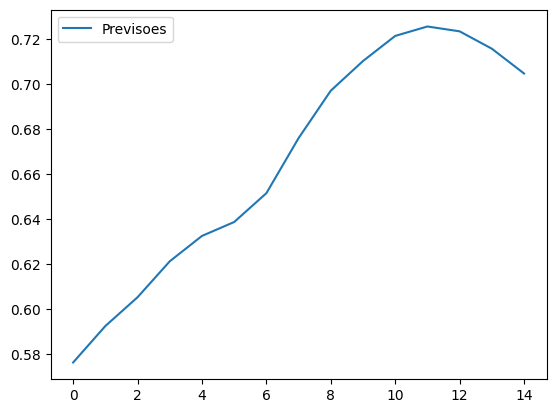

In [229]:
ticker ="PETR3.SA"

base = yf.download(ticker)

base = base[:"2022-03-17"]

previsoes = pd.DataFrame(Realizar_previsoes_randomForest(15,base,320,modelo2),columns=["Previsoes"])
previsoes.plot()

In [214]:
ticker ="PETR3.SA"

base = yf.download(ticker)

df = base[:"2022-01-30"]

df = df.tail(300+37)
tsi = GetTsi(df)
    
#Escala os valores do tsi entre 1 e 2
tsi_scaler_df = EscalarTSI(tsi)

#Removendo a tendência sazonal do tsi
detrended_df = RemoveTendenciaTSI(tsi_scaler_df)

#Aplicando o gaussian no tsi sem a tendência sazonal
detrend_smooth = AplicarGaussianDetrendTSI(detrended_df)

#Normaliza o detrend_smooth
detrend_smooth_normalizado = Normalizar(detrend_smooth)


fig = go.Figure()


fig.add_trace(
    go.Scatter(
        name="TSI Sem tendência",
        x=df.tail(len(detrended_df)).index,
        y=tsi_scaler_df["tsi_scaler"],
        line=dict(color='blue', width=1))
)
'''
fig.add_trace(
    go.Scatter(
        x=df.tail(len(detrended_df)).index,
        y=detrend_smooth["detrend_smooth"],
        mode='lines',
        name='TSI sem tendência - gaussian',
        line=dict(color="orange"))
)
'''

fig.update_layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(0,0,0,0)')
fig.show()

[*********************100%***********************]  1 of 1 completed


In [120]:
fig = go.Figure()


fig.add_trace(
    go.Scatter(
        name="TSI Sem tendência",
        x=base.index,
        y=base["Close"],
        line=dict(color='blue', width=1))
)


fig.update_layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(0,0,0,0)')
fig.show()